<a href="https://colab.research.google.com/github/agi2019/ppi-gci/blob/main/tutorials/01c%20-%20data%20preparation%20(expenditure).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Data preparation – expenditure</center>

Prepared by Omar A. Guerrero (oguerrero@turing.ac.uk, <a href="https://twitter.com/guerrero_oa">@guerrero_oa</a>)

This tutorial will show you how to prepare a dataset containing expenditure programmes that are linked, somehow, to the development indicators. I will assume that the raw expenditure data has already certain structure and pre-processing, and I will provide examples of structures with different levels of granularity. The aim is to prepare two files:

1. A disbursement schedule.
2. A relational table.

## Import the necessary Python libraries to manipulate data

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
#scenario = '_scenario1'
#scenario = '_scenario2'
scenario = '_scenario3'

## On expenditure linked data

In any impact evaluation of public expenditure, it is necessary to obtain information about the level of expenditure that is dedicated to government programmes aiming at improving an indicator. Usually, broad tranches such as education, public health, or national defence are used for that purpose. In the context of multidimensional impact evaluation, these data need to be more disaggregated. In an ideal scenario, there should be one development indicator directly linked to one expenditure programme. In real life, such mapping is more complex because there can be multiple government programmes designed to affect the same indicator, or several indicators affected by the same programme. PPI was designed with these structures in mind.

Today, it is still difficult to find expenditure datasets with a high degree of disaggregation. Thus, in this tutorial, I will show an example where the SDGs serve the function of linking categories. Before elaborating in this example, I need to explain how PPI uses the expenditure data and some important considerations that one needs to take into account before preparing the final dataset.


## PPI and expenditure data

To accommodate different linkages between expenditure and indicators with varied quality, PPI relies on a model of how the government prioritises its spending (see more in the Model chapter of the book). For instance, if there is only aggregate data for the tranche of education, and there are several indicators capturing different policy issues within education, the model determines the spending distribution within this tranche endogenously. However, if the user has data on how the educational budget was actually allocated across more fine-grained policy issues, this information can be incorporated into PPI to rely less on the model and more on the data.


## Temporal factors

Before preparing the example datasets, it is important to mention three important adjustments that should be done beforehand:

* Accounting for inflation.
* Accounting for population growth.
* Accounting for spending inertia.

Controlling for these (and perhaps other) temporal variables is important to remove their influence from the expenditure-indicator relationship that PPI models. Dealing for inflation is straightforward as it consists of turning the expenditure time series in constant monetary units. Removing the influence of population growth is also easy to do as one needs to divide the data by the population size (which changes through time) to obtain per capita spending.

Once the two previous adjustments have been made, there may still be certain inertia in the spending time series. This should also be removed for technical reasons related to the model in PPI. In a nutshell, this is necessary because of the calibration of a parameter $\beta_i$ that normalises the expenditure on indicator $i$ in the 0-1 range to determine the probability of success of the indicator.

Note that $\beta_i$ does not have a time sub-index, so it is a constant parameter. This means that, if the expenditure data related to $i$ has a positive trend, the latter periods of the simulation will tend to have a higher probability of success than the early ones. These inter-temporal differences in success rates is an artefact of not removing the trend component of expenditure, as the indicator data do not suggest a systematic improvement in success rates, but rather that spending in policy issues becomes more expensive–in real terms–with time.

There are various ways in which one could remove the trend component from an expenditure time series. In the book, we use the naive approach of simply calculating the inter-temporal average of each expenditure programme, and applying it in every period. This is a simple approach that meets the technical level of the book, and that is acceptable if one is not concerned about specific points in time during the sample period. However, one may want to consider more nuanced methods like running a linear regression and taking the differences with respect to the predicted values, or a Hodrick–Prescott filter that is popular in macroeconomics, or other signal-processing methods stemming from engineering (as I do in http://dx.doi.org/10.2139/ssrn.4101378).

In this tutorial, I assume that the raw expenditure data consist of a table with time series on government spending on various SDGs; and that these data have already been prepared to account for the aforementioned factors. Hence, in absence of expenditure programmes, the SDGs provide the imperfect link between spending data and indicators.

## Load expenditure data

In [19]:
data_exp = pd.read_csv('C:/Users/rha005/OneDrive - CSIRO/Documents/7. CSIRO/00. Work in Progress - ON Office/Week 9-10/ppi-gci-main-indicators/tutorials/raw_data'+scenario+'/raw_expenditure.csv')
data_indi = pd.read_csv('C:/Users/rha005/OneDrive - CSIRO/Documents/7. CSIRO/00. Work in Progress - ON Office/Week 9-10/ppi-gci-main-indicators/tutorials/clean_data'+scenario+'/data_indicators.csv')

In [20]:
data_exp

,seriesCode,2020,2021,2022,2023,2024,sdg,yearTotal
0,gci11_Lolsafety,1.178240e+08,0.000000e+00,369324000,461966000,1.479349e+09,11,2.428463e+09
1,gci11_Lforgery,8.751650e+08,1.145130e+08,7300000,270068000,4.982700e+07,11,1.316873e+09
2,gci11_Lonline,2.373030e+08,3.530940e+08,708483000,2995641000,0.000000e+00,11,4.294521e+09
3,gci12_Rpdp,1.683348e+09,6.352000e+07,0,925692000,2.884810e+08,12,2.961041e+09
4,gci12_Rprivacy,1.324220e+08,1.066716e+09,179893000,14200000,6.736580e+08,12,2.066889e+09
...,...,...,...,...,...,...,...,...
58,gci52_Mcapacitydev,9.716000e+06,0.000000e+00,0,307637000,0.000000e+00,52,3.173530e+08
59,gci53_Mlat,0.000000e+00,0.000000e+00,0,0,0.000000e+00,53,0.000000e+00
60,gci54_PPPdomestic,1.577239e+09,8.413280e+08,686554000,812315000,4.608430e+08,54,4.378279e+09
61,gci54_PPPforeign,1.000000e+08,0.000000e+00,0,263520000,1.170940e+08,54,4.806140e+08


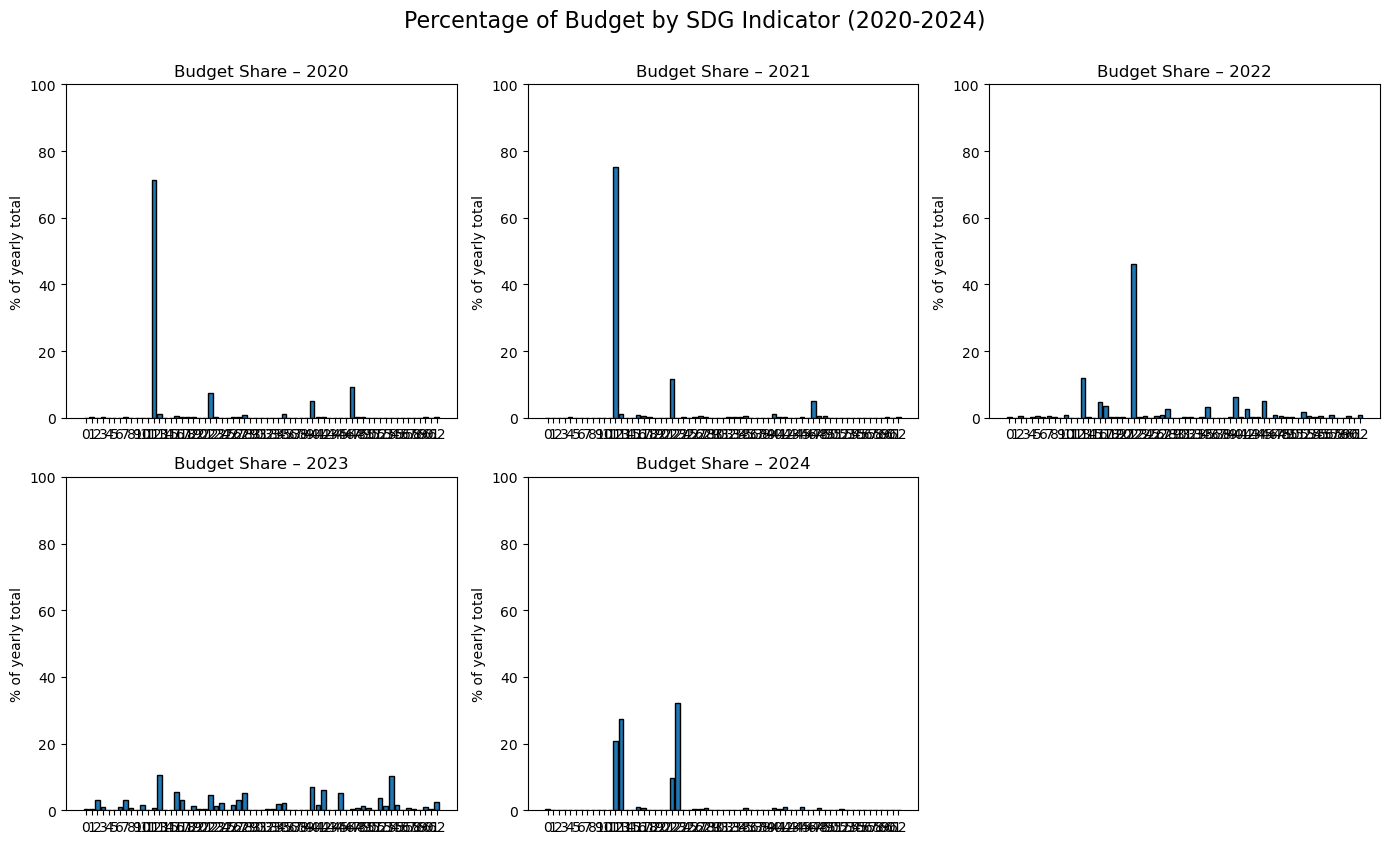

In [21]:
# list of year columns we care about
years = ['2020', '2021', '2022', '2023', '2024']

# ------------------------------------------------------------------
# 2) CALCULATE YEARLY PERCENTAGES ----------------------------------
# ------------------------------------------------------------------
# divide each column by the column sum → multiply by 100 for %
percent_data_exp = data_exp[years].div(data_exp[years].sum(axis=0), axis=1) * 100

# ------------------------------------------------------------------
# 3) PLOT FIVE BAR CHARTS ------------------------------------------
# ------------------------------------------------------------------
plt.figure(figsize=(14, 8))

for i, year in enumerate(years, start=1):
    plt.subplot(2, 3, i)                # arrange in a 2×3 grid
    plt.bar(percent_data_exp.index.astype(str),
            percent_data_exp[year],
            edgecolor='black')
    plt.title(f'Budget Share – {year}')
    plt.ylabel('% of yearly total')
    plt.ylim(0, 100)
    plt.xticks(rotation=0)

plt.tight_layout()
plt.suptitle('Percentage of Budget by SDG Indicator (2020‑2024)', fontsize=16, y=1.05)
plt.show()

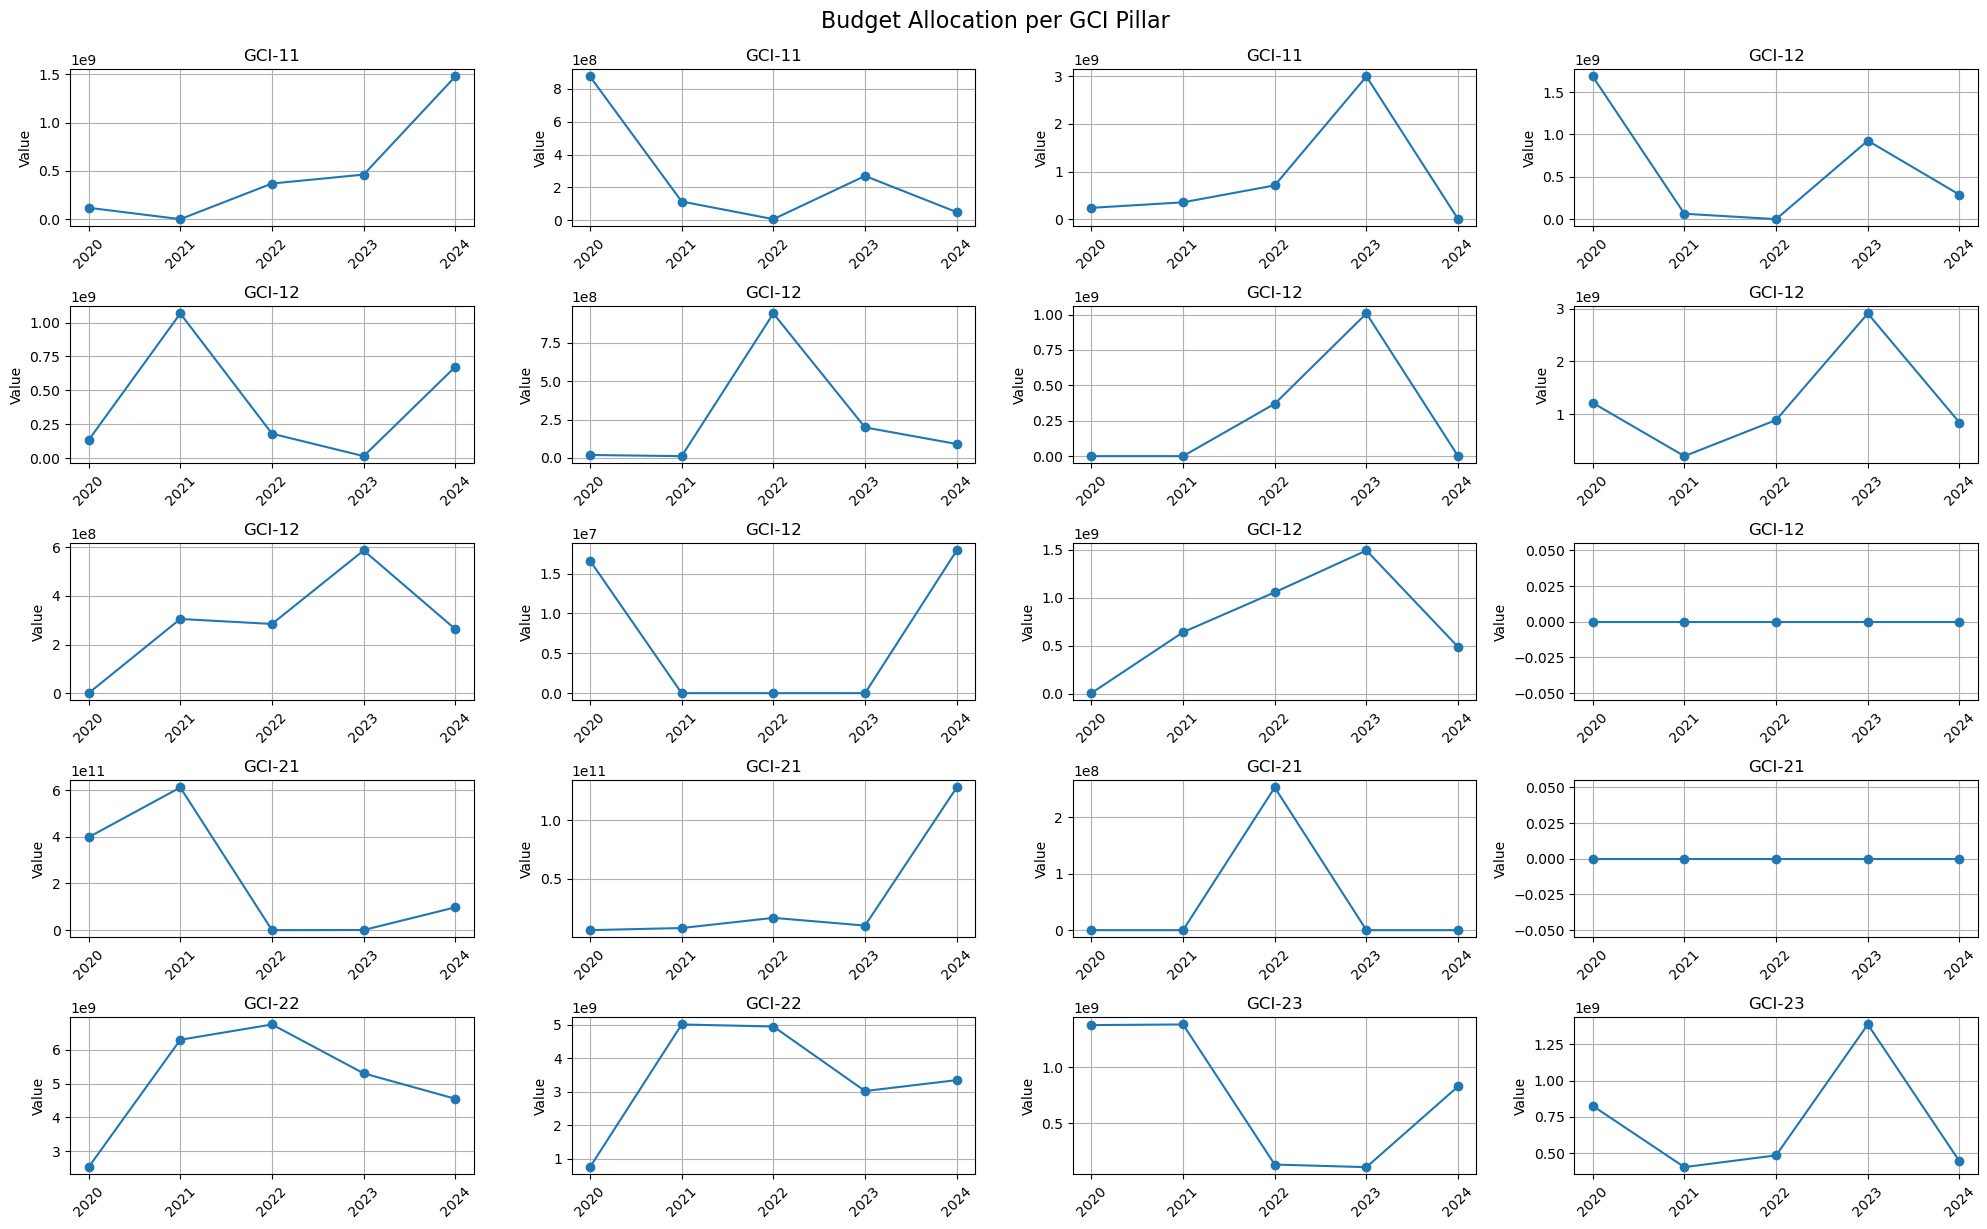

In [22]:
years = ['2020', '2021', '2022', '2023', '2024']
max_rows = min(len(data_exp), 20)  # show up to 20 SDGs

# --- 3. Plot ---
plt.figure(figsize=(20, 12))  # Adjust size for readability

for i in range(max_rows):
    plt.subplot(5, 4, i + 1)  # 5 rows × 4 cols = 20 plots
    row = data_exp.iloc[i]
    plt.plot(years, row[years].values, marker='o')
    plt.title(f'GCI-{int(row["sdg"])}')
    plt.xticks(rotation=45)
    plt.ylabel('Value')
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Budget Allocation per GCI Pillar', fontsize=16, y=1.02)
plt.show()

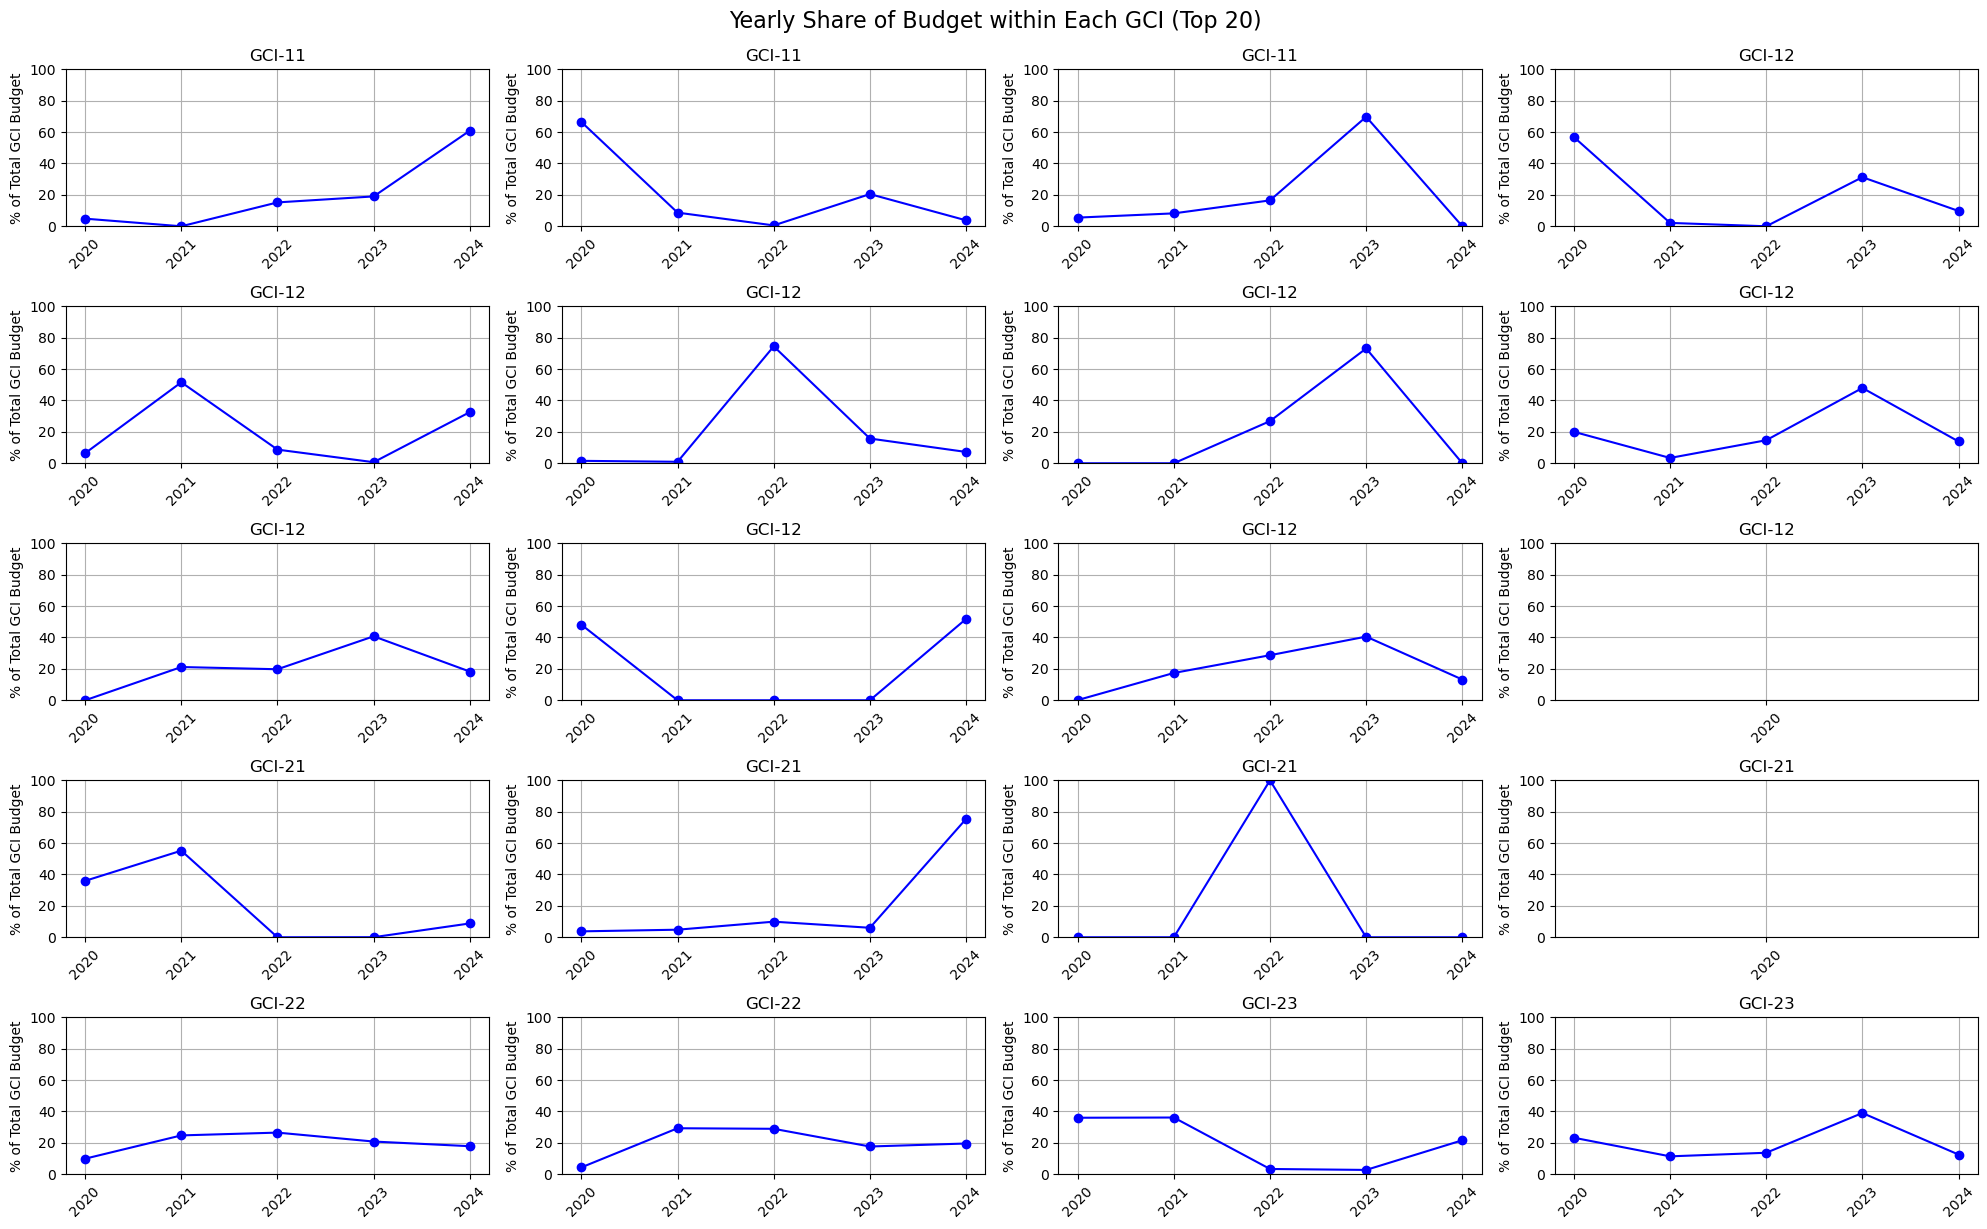

In [23]:
years = ['2020', '2021', '2022', '2023', '2024']
max_rows = min(len(data_exp), 20)  # Maksimal 20 SDG

# Hitung persentase per GCI (row-wise normalization)
df_percent = data_exp.copy()
df_percent[years] = df_percent[years].div(df_percent[years].sum(axis=1), axis=0) * 100

# Plot line chart
plt.figure(figsize=(20, 12))

for i in range(max_rows):
    plt.subplot(5, 4, i + 1)  # Grid 5×4
    row = df_percent.iloc[i]
    plt.plot(years, row[years].values, marker='o', color='blue')
    plt.title(f'GCI-{int(row["sdg"])}')
    plt.ylim(0, 100)
    plt.ylabel('% of Total GCI Budget')
    plt.xticks(rotation=45)
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Yearly Share of Budget within Each GCI (Top 20)', fontsize=16, y=1.02)
plt.show()

First, let me check which GCIs are covered in both the expenditure and the indicators datasets. Then, I need to make sure that every GCI has at least one instrumental indicator.

In [24]:
data_exp = data_exp[data_exp.sdg.isin(data_indi.sdg.values)]

In [25]:
data_exp

,seriesCode,2020,2021,2022,2023,2024,sdg,yearTotal
0,gci11_Lolsafety,1.178240e+08,0.000000e+00,369324000,461966000,1.479349e+09,11,2.428463e+09
1,gci11_Lforgery,8.751650e+08,1.145130e+08,7300000,270068000,4.982700e+07,11,1.316873e+09
2,gci11_Lonline,2.373030e+08,3.530940e+08,708483000,2995641000,0.000000e+00,11,4.294521e+09
3,gci12_Rpdp,1.683348e+09,6.352000e+07,0,925692000,2.884810e+08,12,2.961041e+09
4,gci12_Rprivacy,1.324220e+08,1.066716e+09,179893000,14200000,6.736580e+08,12,2.066889e+09
...,...,...,...,...,...,...,...,...
58,gci52_Mcapacitydev,9.716000e+06,0.000000e+00,0,307637000,0.000000e+00,52,3.173530e+08
59,gci53_Mlat,0.000000e+00,0.000000e+00,0,0,0.000000e+00,53,0.000000e+00
60,gci54_PPPdomestic,1.577239e+09,8.413280e+08,686554000,812315000,4.608430e+08,54,4.378279e+09
61,gci54_PPPforeign,1.000000e+08,0.000000e+00,0,263520000,1.170940e+08,54,4.806140e+08


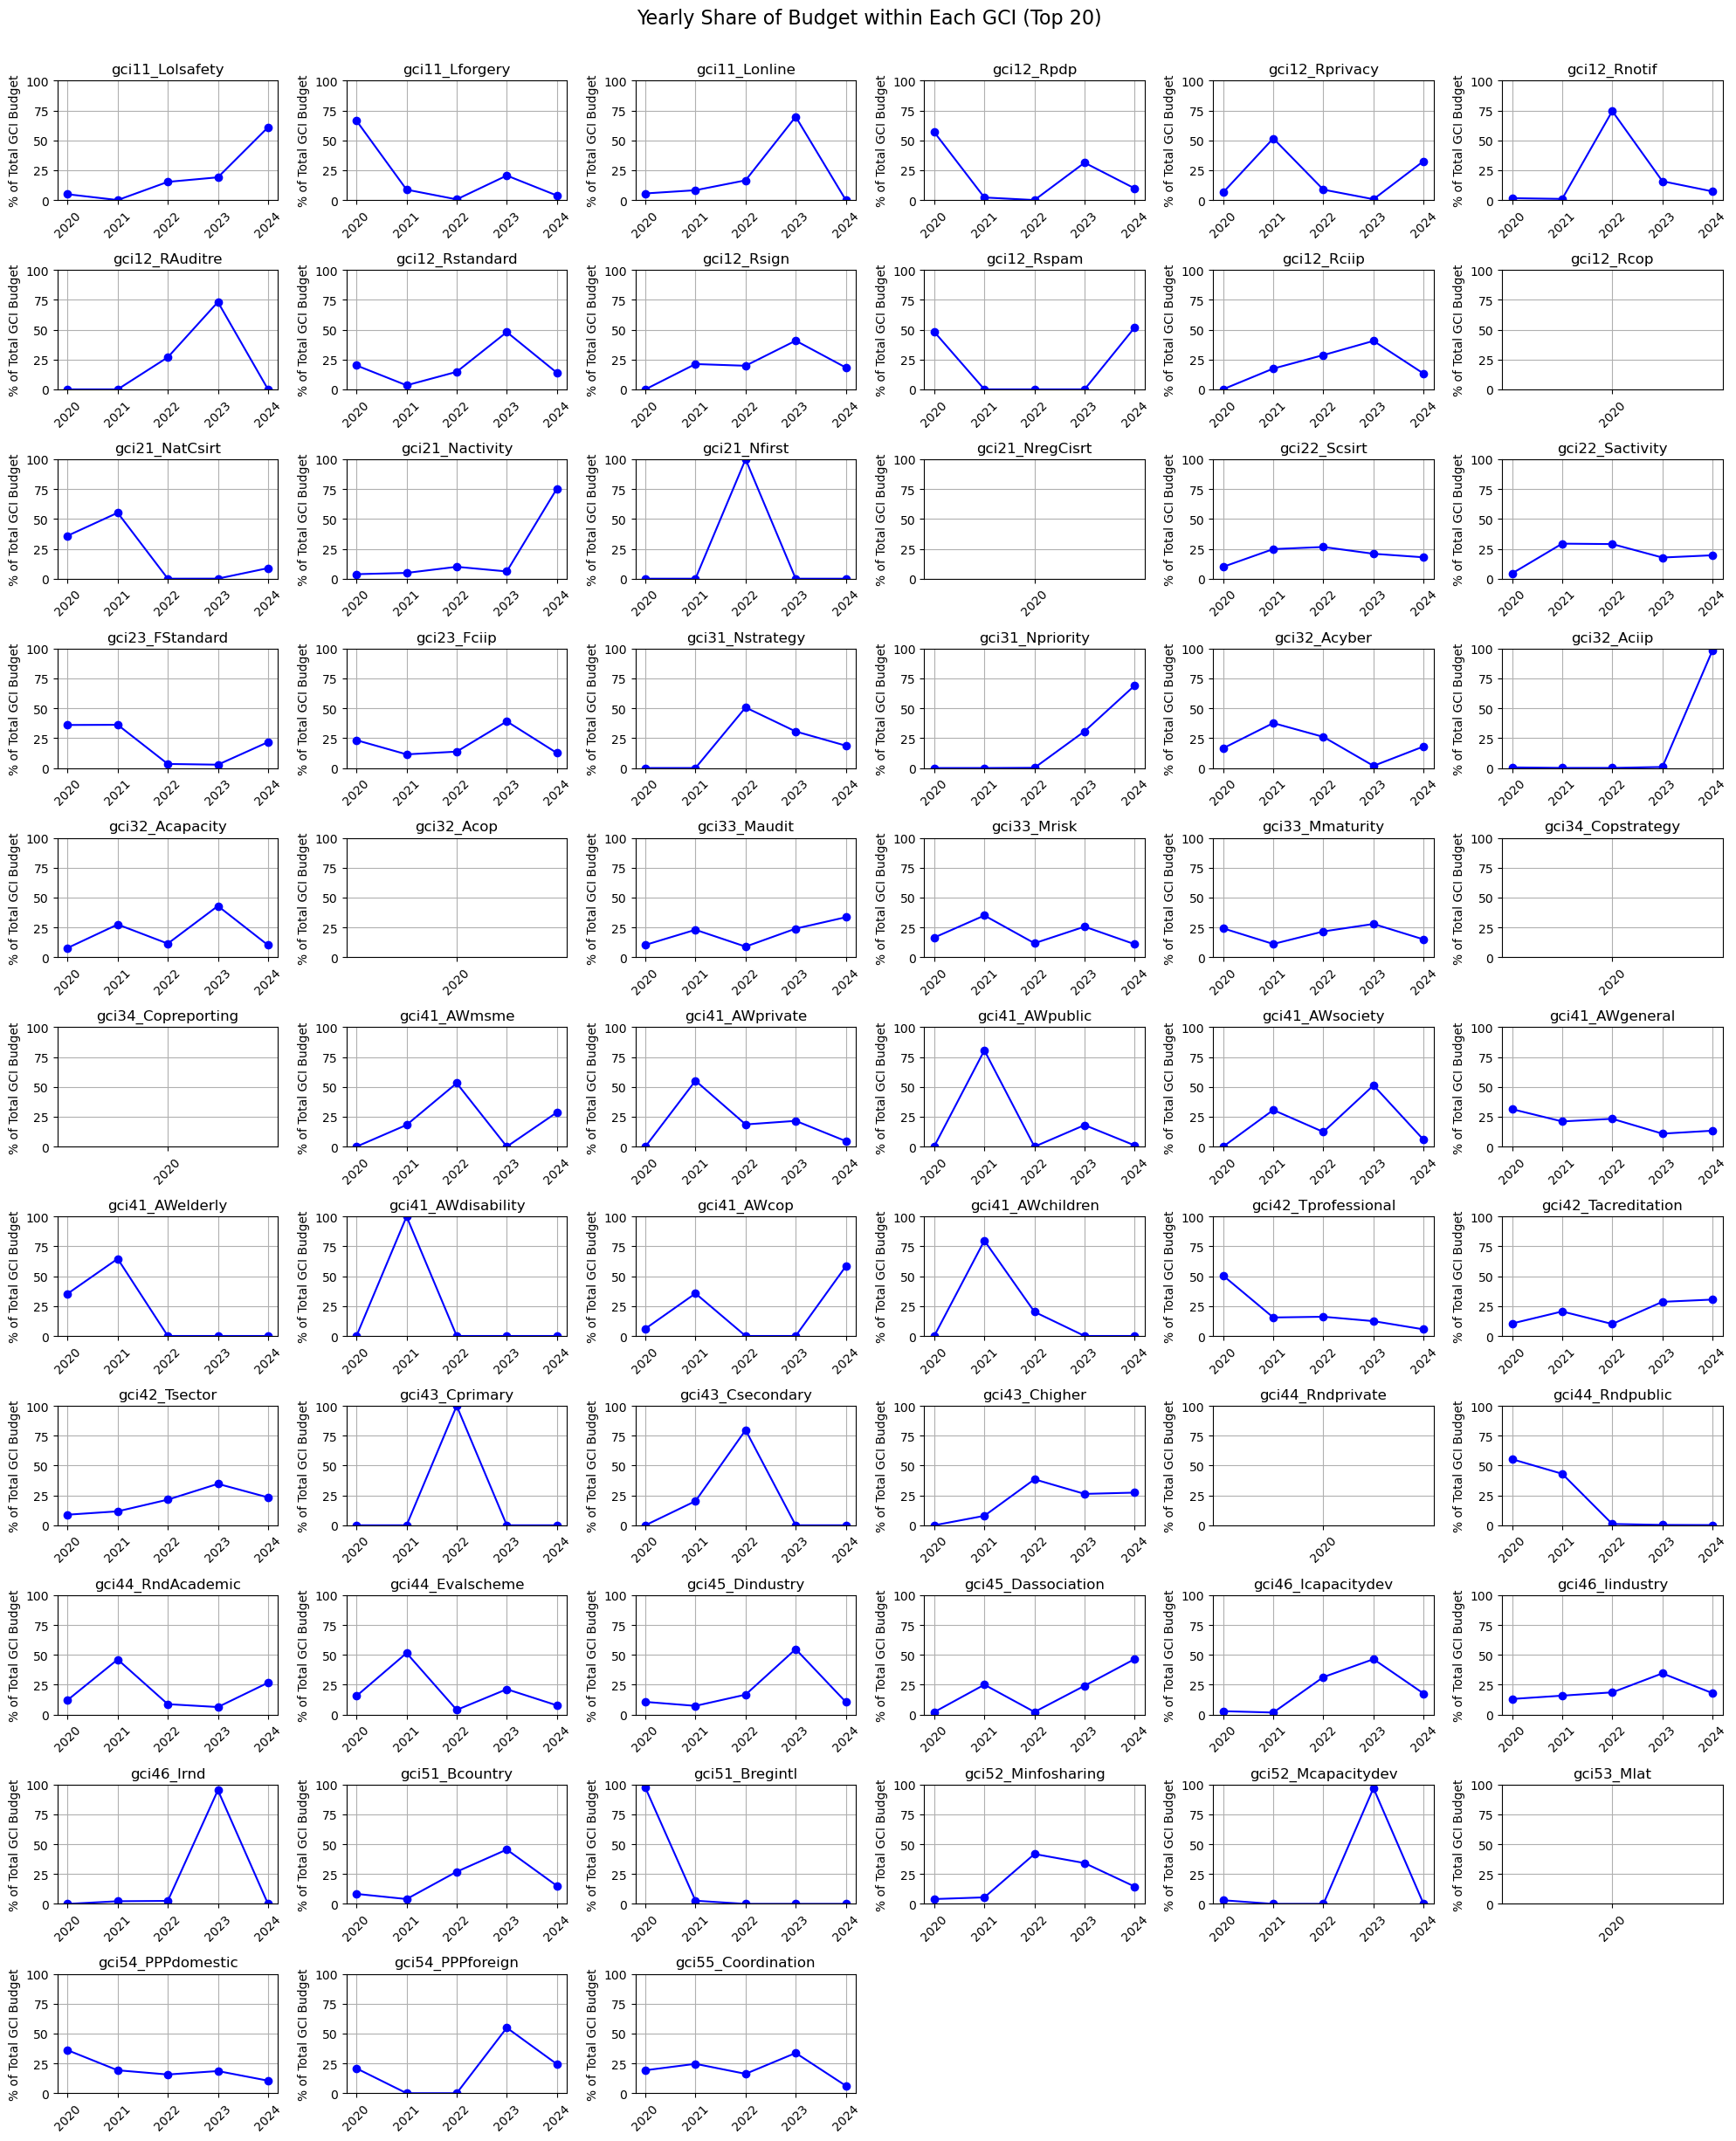

In [26]:
years = ['2020', '2021', '2022', '2023', '2024']
max_rows = min(len(data_exp), 63)  # Maksimal 20 SDG

# Hitung persentase per GCI (row-wise normalization)
df_percent = data_exp.copy()
df_percent[years] = df_percent[years].div(df_percent[years].sum(axis=1), axis=0) * 100

# Plot line chart
plt.figure(figsize=(20, 24))

for i in range(max_rows):
    plt.subplot(11, 6, i + 1)  # Grid 5×4
    row = df_percent.iloc[i]
    plt.plot(years, row[years].values, marker='o', color='blue')
    plt.title(row["seriesCode"])
    plt.ylim(0, 100)
    plt.ylabel('% of Total GCI Budget')
    plt.xticks(rotation=45)
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Yearly Share of Budget within Each GCI (Top 20)', fontsize=16, y=1.02)
plt.show()

## Assembling disbursement schedule

The following step is crucial, so read carefuly. In PPI, each simulation runs for $T$ steps. Each of these simulation steps <strong>does not</strong> correspond to a calendar period. Thus, the user needs to convert the expenditure data into a format that matches the number of simulation steps. Since most indicator and expenditure data are relatively short, $T$ tends to be larger than the sample period. Therefore, the expenditure series need to be "streched" to provide the government agent with a disbursement schedule that determines the level of spending in each simulation step.

For these tutorials, let me use $T=69$, so that three simulation steps are equivalent to one calendar year (because there are 23 years in the data). The Calibration chapter of the book explains that the choice of $T$ should be at least 40 to give enough time to the agents to learn and establish a social norm of inefficiency. Values beyond 50 do not change the results in a significant way, but rather impose a computational burden. Thus, it is recommended to establish a $T$ between 40 and 200 that is easy to translate into calendar time.

$T=69$ means that the government spends every four months. To adjust the data to $T$, I will assume that, within each year, the government spends the same amount every four months. Effectively, this means that one only needs to divide each annual observation by 3 and repeat it three times to elongate the time series. Of course, one does not need to assume an even temporal split. If nuanced information about how the government spends its resources is available, it is easy to introduce a more detailed disbursement schedule.

In [27]:
years = [column_name for column_name in data_exp.columns if str(column_name).isnumeric()]
periods = len(years)
T = 60
t = int(T/periods)

new_rows = []
for index, row in data_exp.iterrows():
    new_row = [row.seriesCode]
    for year in years:
        new_row += [row[year] for i in range(t)]
    new_rows.append(new_row)

df_exp = pd.DataFrame(new_rows, columns=['seriesCode']+list(range(T)))

In [28]:
df_exp

,seriesCode,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,59
0,gci11_Lolsafety,1.178240e+08,1.178240e+08,1.178240e+08,1.178240e+08,1.178240e+08,1.178240e+08,1.178240e+08,1.178240e+08,1.178240e+08,...,1.479349e+09,1.479349e+09,1.479349e+09,1.479349e+09,1.479349e+09,1.479349e+09,1.479349e+09,1.479349e+09,1.479349e+09,1.479349e+09
1,gci11_Lforgery,8.751650e+08,8.751650e+08,8.751650e+08,8.751650e+08,8.751650e+08,8.751650e+08,8.751650e+08,8.751650e+08,8.751650e+08,...,4.982700e+07,4.982700e+07,4.982700e+07,4.982700e+07,4.982700e+07,4.982700e+07,4.982700e+07,4.982700e+07,4.982700e+07,4.982700e+07
2,gci11_Lonline,2.373030e+08,2.373030e+08,2.373030e+08,2.373030e+08,2.373030e+08,2.373030e+08,2.373030e+08,2.373030e+08,2.373030e+08,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,gci12_Rpdp,1.683348e+09,1.683348e+09,1.683348e+09,1.683348e+09,1.683348e+09,1.683348e+09,1.683348e+09,1.683348e+09,1.683348e+09,...,2.884810e+08,2.884810e+08,2.884810e+08,2.884810e+08,2.884810e+08,2.884810e+08,2.884810e+08,2.884810e+08,2.884810e+08,2.884810e+08
4,gci12_Rprivacy,1.324220e+08,1.324220e+08,1.324220e+08,1.324220e+08,1.324220e+08,1.324220e+08,1.324220e+08,1.324220e+08,1.324220e+08,...,6.736580e+08,6.736580e+08,6.736580e+08,6.736580e+08,6.736580e+08,6.736580e+08,6.736580e+08,6.736580e+08,6.736580e+08,6.736580e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,gci52_Mcapacitydev,9.716000e+06,9.716000e+06,9.716000e+06,9.716000e+06,9.716000e+06,9.716000e+06,9.716000e+06,9.716000e+06,9.716000e+06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
59,gci53_Mlat,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
60,gci54_PPPdomestic,1.577239e+09,1.577239e+09,1.577239e+09,1.577239e+09,1.577239e+09,1.577239e+09,1.577239e+09,1.577239e+09,1.577239e+09,...,4.608430e+08,4.608430e+08,4.608430e+08,4.608430e+08,4.608430e+08,4.608430e+08,4.608430e+08,4.608430e+08,4.608430e+08,4.608430e+08
61,gci54_PPPforeign,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,...,1.170940e+08,1.170940e+08,1.170940e+08,1.170940e+08,1.170940e+08,1.170940e+08,1.170940e+08,1.170940e+08,1.170940e+08,1.170940e+08


## The relational table

The last part of this tutorial consists of building a dataset linking each expenditure programme to the indicators that it is supposed to affect. This dataset consists of a table with the unique ids of the indicators in the first column, and the ids of the programmes that are designed to affect them along the rest of the columns (as many columns as needed). Recall that, in this tutorial the SDGs act as programmes. In addition, you need to make sure that:

* All instrumental indicators are reported in this table.
* All programmes (SDGs) that appear in the disbursement schedule also appear in this table.
* All the indicators reported in this table are only instrumental.
* All programmes (SDGs) are designed to affect at least one instrumental indicator.

Failure to comply with any of these requirements will make PPI to throw an exception.

In [29]:
is_instrumental = dict(zip(data_indi.seriesCode, data_indi.instrumental==1))

rel_dict = dict([(code, []) for code in data_indi.seriesCode if is_instrumental[code]])
for index, row in data_indi.iterrows():
    if row.seriesCode in rel_dict:
        rel_dict[row.seriesCode].append(row.sdg)

n_cols = max([len(value) for value in rel_dict.values()])

M = [['' for i in range(n_cols+1)] for code in rel_dict.values()]
for i, items in enumerate(rel_dict.items()):
    sdg, indis = items
    M[i][0] = sdg
    for j, indi in enumerate(indis):
        M[i][j+1] = indi

df_rel = pd.DataFrame(M, columns=['seriesCode']+list(range(n_cols)))

In [30]:
df_rel

,seriesCode,0
0,gci11_Lonline,11
1,gci11_Lforgery,11
2,gci11_Lolsafety,11
3,gci12_Rpdp,12
4,gci12_Rprivacy,12
5,gci12_Rnotif,12
6,gci12_RAuditre,12
7,gci12_Rstandard,12
8,gci12_Rsign,12
9,gci12_Rspam,12


## Save data

In [31]:
df_exp.to_csv('C:/Users/rha005/OneDrive - CSIRO/Documents/7. CSIRO/00. Work in Progress - ON Office/Week 9-10/ppi-gci-main-indicators/tutorials/clean_data'+scenario+'/data_expenditure.csv', index=False)


In [32]:
df_rel.to_csv('C:/Users/rha005/OneDrive - CSIRO/Documents/7. CSIRO/00. Work in Progress - ON Office/Week 9-10/ppi-gci-main-indicators/tutorials/clean_data'+scenario+'/data_relational_table.csv', index=False)